# Hierarchical Risk Parity Portfolios

In [2]:
import warnings
warnings.filterwarnings("ignore")

from pathlib import Path

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import PercentFormatter

plt.style.use("seaborn-v0_8-whitegrid")

# Path configuration (adjust base_dir if your CSV files live elsewhere)

In [3]:
base_dir = Path.cwd()
correlation_path = base_dir / "cormat.csv"
covariance_path = base_dir / "covmat.csv"

correlation_path, covariance_path

(WindowsPath('c:/my-git/DataScience-novaIMS/AssetPricingPortfolio/aulas/cormat.csv'),
 WindowsPath('c:/my-git/DataScience-novaIMS/AssetPricingPortfolio/aulas/covmat.csv'))

# Read Marcos Lopez de Prado (2016) paper data

In [4]:
cor_mat = pd.read_csv(correlation_path, header=None, sep=";", decimal=",", dtype=float)
cov_mat = pd.read_csv(covariance_path, header=None, sep=";", decimal=",", dtype=float)

cor_mat.shape, cov_mat.shape

((10, 10), (10, 10))

# Hierarchical Clustering

In [5]:
distance_matrix = pdist(cor_mat.values, metric="euclidean")
linkage_single = linkage(distance_matrix, method="single")
cluster_order = leaves_list(linkage_single)
cluster_order

array([8, 1, 9, 0, 6, 2, 5, 3, 4, 7], dtype=int32)

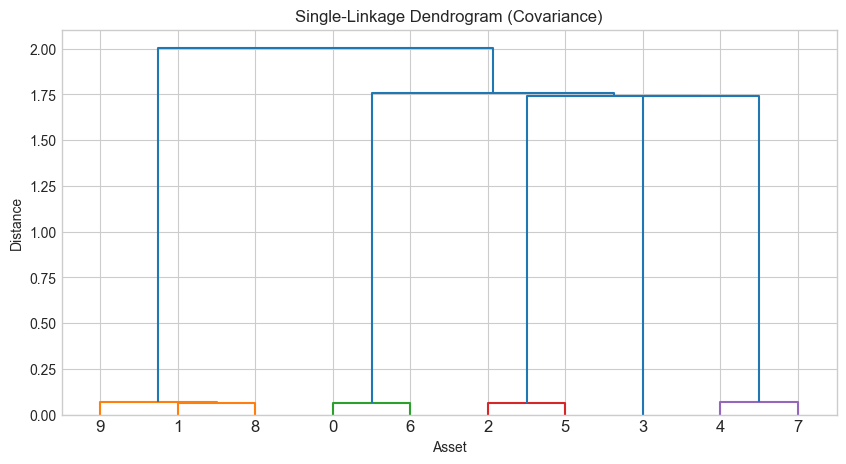

In [6]:
plt.figure(figsize=(10, 5))
distance_cov = pdist(cov_mat.values, metric="euclidean")
linkage_single_cov = linkage(distance_cov, method="single")
dendrogram(linkage_single_cov, color_threshold=None)
plt.title("Single-Linkage Dendrogram (Covariance)")
plt.xlabel("Asset")
plt.ylabel("Distance")
plt.show()

# Helper functions (Inverse-Variance, cluster variance, recursive bisection)

In [8]:
def get_inverse_variance_weights(covariance: np.ndarray) -> np.ndarray:
    """Compute inverse-variance portfolio weights."""
    variances = np.diag(covariance)
    inv_variances = 1.0 / variances
    weights = inv_variances / inv_variances.sum()
    return weights


def get_cluster_variance(covariance: pd.DataFrame, cluster_indices: np.ndarray) -> float:
    """Compute variance of a cluster using IVP weights."""
    sub_cov = covariance.iloc[cluster_indices, cluster_indices].to_numpy()
    weights = get_inverse_variance_weights(sub_cov)
    return float(weights.T @ sub_cov @ weights)


def recursive_bisection(covariance: pd.DataFrame, ordered_indices: np.ndarray) -> np.ndarray:
    """Apply López de Prado's recursive bisection to obtain HRP weights."""
    weights = np.ones(len(covariance))

    def _split(index_subset: np.ndarray) -> None:
        if len(index_subset) <= 1:
            return

        split_point = len(index_subset) // 2
        left = index_subset[:split_point]
        right = index_subset[split_point:]

        var_left = get_cluster_variance(covariance, left)
        var_right = get_cluster_variance(covariance, right)
        allocation = 1.0 - var_left / (var_left + var_right)

        weights[left] *= allocation
        weights[right] *= (1.0 - allocation)

        _split(left)
        _split(right)

    _split(ordered_indices)
    normalized = weights / weights.sum()
    return normalized

# Hierarchical Risk Parity Portfolio (HRPP) vs Inverse-Variance Portfolio (IVP)

In [9]:
hrp_weights = recursive_bisection(cov_mat, cluster_order)
ivp_weights = get_inverse_variance_weights(cov_mat.to_numpy())

weights_df = pd.DataFrame({
    "Asset": np.arange(1, len(hrp_weights) + 1),
    "HRP": hrp_weights,
    "IVP": ivp_weights
})
weights_df

,Asset,HRP,IVP
0,1,0.069994,0.103622
1,2,0.075922,0.102762
2,3,0.108389,0.103613
3,4,0.190291,0.102474
4,5,0.097199,0.103088
5,6,0.101915,0.097424
6,7,0.066189,0.097989
7,8,0.090959,0.096470
8,9,0.071239,0.096424
9,10,0.127903,0.096134


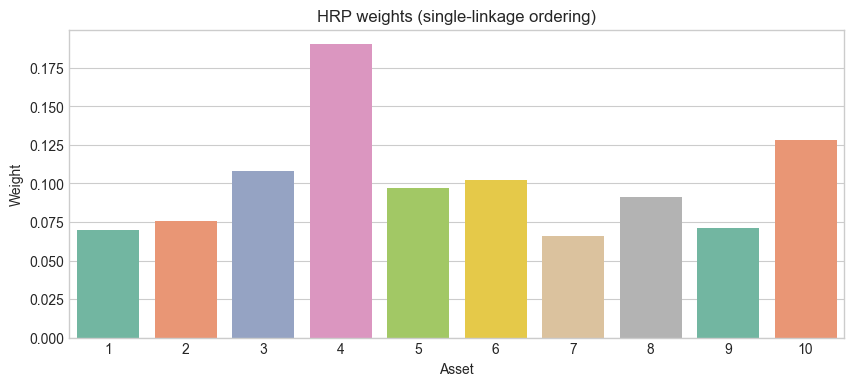

In [10]:
plt.figure(figsize=(10, 4))
sns.barplot(x=weights_df["Asset"], y=weights_df["HRP"], palette="Set2")
plt.title("HRP weights (single-linkage ordering)")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.show()

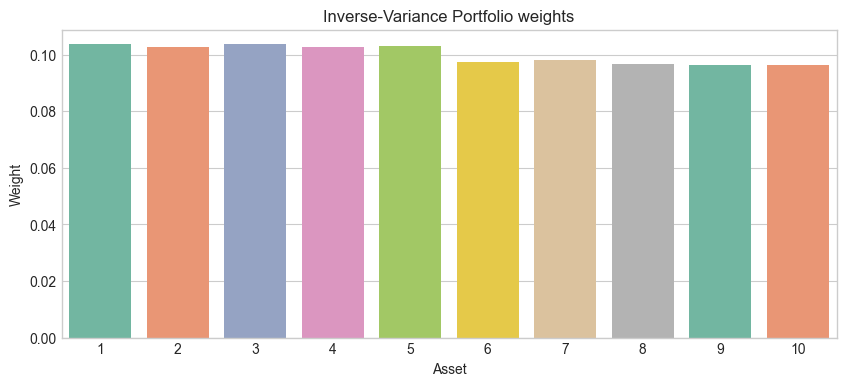

In [11]:
plt.figure(figsize=(10, 4))
sns.barplot(x=weights_df["Asset"], y=weights_df["IVP"], palette="Set2")
plt.title("Inverse-Variance Portfolio weights")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.show()

# Hierarchical Risk Parity using different linkage methods

In [12]:
def hrp_for_linkage(covariance: pd.DataFrame, method: str) -> np.ndarray:
    distance = pdist(covariance.values, metric="euclidean")
    linkage_matrix = linkage(distance, method=method)
    ordering = leaves_list(linkage_matrix)
    return recursive_bisection(covariance, ordering)

linkage_methods = ["single", "complete", "average", "ward"]

weights_by_method = {
    method: hrp_for_linkage(cov_mat, method)
    for method in linkage_methods
}

weights_table = pd.DataFrame(
    weights_by_method,
    index=pd.Index(np.arange(1, len(hrp_weights) + 1), name="Asset")
)
weights_table

,single,complete,average,ward
Asset,,,,
1,0.069822,0.108278,0.108278,0.108278
2,0.076168,0.075866,0.075866,0.075866
3,0.108389,0.097794,0.097794,0.097794
4,0.190291,0.190540,0.190540,0.190540
5,0.097199,0.069403,0.069403,0.069403
6,0.101915,0.091953,0.091953,0.091953
7,0.066027,0.102392,0.102392,0.102392
8,0.090959,0.064948,0.064948,0.064948
9,0.127974,0.127852,0.127852,0.127852


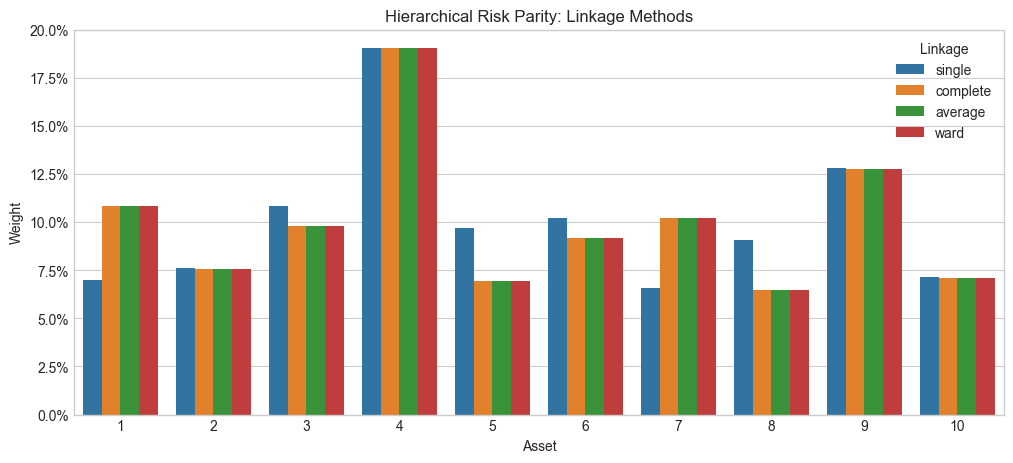

In [13]:
df_plot = (
    weights_table
    .reset_index()
    .melt(id_vars="Asset", var_name="Linkage", value_name="Weight")
)

plt.figure(figsize=(12, 5))
sns.barplot(data=df_plot, x="Asset", y="Weight", hue="Linkage")
plt.title("Hierarchical Risk Parity: Linkage Methods")
plt.xlabel("Asset")
plt.ylabel("Weight")
plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=1))
plt.legend(title="Linkage")
plt.show()